## 1. Environment Setup and Dependencies Installation

In [45]:
# Install required packages
!pip install torch torchvision torchaudio timm numpy scikit-learn matplotlib pandas wildlife-datasets tqdm

In [46]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import NearestNeighbors
from transformers import AutoModel
import timm
from sklearn.model_selection import train_test_split

In [47]:
# Check if running in Kaggle or Colab
IN_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
IN_COLAB = 'google.colab' in sys.modules

if IN_KAGGLE:
    print("Running in Kaggle")
    # Set data path
    DATA_PATH = '/kaggle/input/animal-clef-2025'
elif IN_COLAB:
    print("Running in Google Colab")
    # Mount Google Drive if in Colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Install required packages
    !pip install -q git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
    !pip install -q git+https://github.com/WildlifeDatasets/wildlife-tools
    !pip install -q timm transformers
# Set data path
    DATA_PATH = '/content/drive/MyDrive/5524_CVEVAN/animal-clef-2025'
else:
    print("Running in local environment")
    # Set appropriate path for your environment
    DATA_PATH = './animal-clef-2025'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

Running in local environment
Using device: cuda


## 2. Load and Explore Dataset

In [48]:
# Load metadata
metadata = pd.read_csv(os.path.join(DATA_PATH, 'metadata.csv'))
print(f"Metadata shape: {metadata.shape}")
metadata.head()

Metadata shape: (15209, 8)


,image_id,identity,path,date,orientation,species,split,dataset
0,0,LynxID2025_lynx_37,images/LynxID2025/database/000f9ee1aad063a4485...,NaN,right,lynx,database,LynxID2025
1,1,LynxID2025_lynx_37,images/LynxID2025/database/0020edb6689e9f78462...,NaN,left,lynx,database,LynxID2025
2,2,LynxID2025_lynx_49,images/LynxID2025/database/003152e4145b5b69400...,NaN,left,lynx,database,LynxID2025
3,3,NaN,images/LynxID2025/query/003b89301c7b9f6d18f722...,NaN,back,lynx,query,LynxID2025
4,4,LynxID2025_lynx_13,images/LynxID2025/database/003c3f82011e9c3f849...,NaN,right,lynx,database,LynxID2025


Total images: 15209
Database images: 13074
Query images: 2135

Species distribution:
species
loggerhead turtle    9229
lynx                 3903
salamander            689
Name: count, dtype: int64


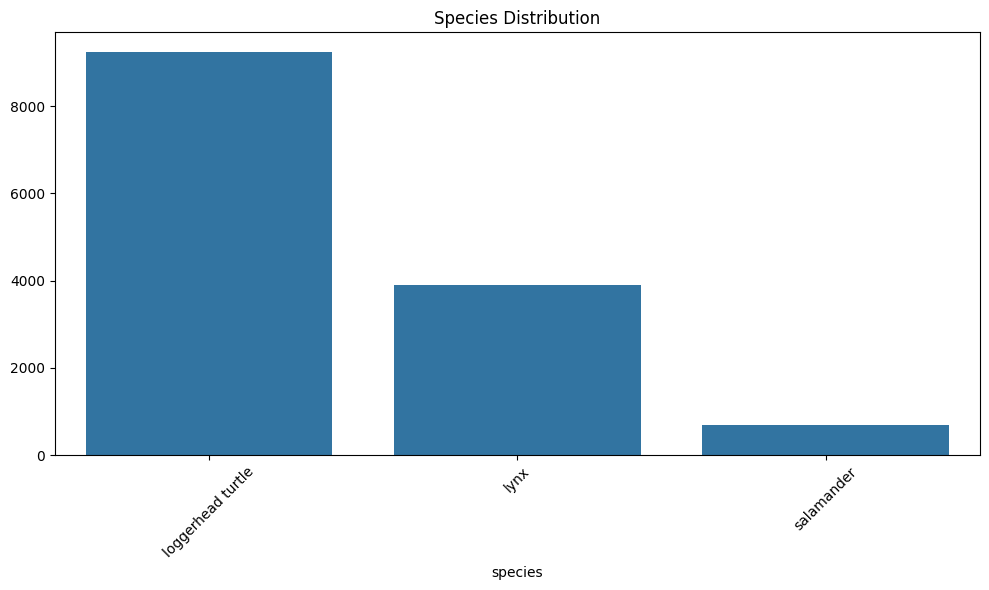


Number of unique individuals: 1102


In [49]:
import seaborn as sns

# Explore dataset statistics
print(f"Total images: {len(metadata)}")
print(f"Database images: {len(metadata[metadata['split'] == 'database'])}")
print(f"Query images: {len(metadata[metadata['split'] == 'query'])}")

# Count species
species_counts = metadata['species'].value_counts()
print("\nSpecies distribution:")
print(species_counts)

# Visualize species distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=species_counts.index, y=species_counts.values)
plt.title('Species Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Count unique individuals
unique_individuals = metadata[metadata['identity'].notna()]['identity'].nunique()
print(f"\nNumber of unique individuals: {unique_individuals}")

In [50]:
# Define image transformations

# Create custom dataset class
class AnimalReIDDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, root_dir, transform=None, split='database'):
        self.metadata = metadata[metadata['split'] == split].reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.split = split

        # Create label mapping for identities
        if split in ['database', 'train']:
            self.identities = sorted(self.metadata['identity'].dropna().unique())
            self.identity_to_idx = {identity: idx for idx, identity in enumerate(self.identities)}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.root_dir, row['path'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # For database images, return image, identity index, and identity
        # if self.metadata['split'].iloc[0] == 'database':
        if self.split in ['database', 'train']:
            identity = row['identity']
            if pd.isna(identity):
                identity_idx = -1  # For images without identity
            else:
                identity_idx = self.identity_to_idx[identity]
            return image, identity_idx, identity
        # For query images, return image and image_id
        else:
            return image, row['image_id']

## 4. Feature Extraction and Retrieval Functions

In [51]:
# Extract embeddings from database images
def extract_database_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    identities = []

    with torch.no_grad():
        for images, _, identity in tqdm(data_loader, desc='Extracting database embeddings'):
            images = images.to(device)
            batch_embeddings = model(images)
            embeddings.append(batch_embeddings.cpu().numpy())
            identities.extend(identity)

    embeddings = np.vstack(embeddings)
    return embeddings, identities

# Extract embeddings from query images
def extract_query_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    image_ids = []

    with torch.no_grad():
        for images, ids in tqdm(data_loader, desc='Extracting query embeddings'):
            images = images.to(device)
            batch_embeddings = model(images)
            embeddings.append(batch_embeddings.cpu().numpy())
            image_ids.extend(ids.numpy())

    embeddings = np.vstack(embeddings)
    return embeddings, image_ids

# Perform retrieval using k-nearest neighbors
def perform_retrieval(db_embeddings, query_embeddings, db_identities, query_ids, k=5, threshold=0.7):
    # Initialize k-nearest neighbors
    knn = NearestNeighbors(n_neighbors=min(k, len(db_embeddings)), metric='cosine')
    knn.fit(db_embeddings)

    # Find k-nearest neighbors for each query
    distances, indices = knn.kneighbors(query_embeddings)

    # Convert distances to similarities (1 - distance)
    similarities = 1 - distances

    # Make predictions
    predictions = []
    for i, (sims, idxs) in enumerate(zip(similarities, indices)):
        query_id = query_ids[i]

        # Check if the highest similarity is above threshold
        if sims[0] > threshold:
            # Predict the identity of the most similar database image
            prediction = db_identities[idxs[0]]
        else:
            # Predict as new individual
            prediction = 'new_individual'

        predictions.append({'image_id': int(query_id), 'prediction': prediction})

    return predictions

## 5. Evaluation Metrics

In [52]:
# Evaluate predictions
def evaluate_predictions(predictions, ground_truths):
    """
    Calculate evaluation metrics for the predictions

    Args:
        predictions: List of predicted identities
        ground_truths: List of ground truth identities

    Returns:
        metrics: Dictionary with evaluation metrics
    """
    # Convert predictions and ground truths to binary format for metrics calculation
    # 1 for known individual, 0 for new individual
    y_pred_binary = [0 if p == 'new_individual' else 1 for p in predictions]
    y_true_binary = [0 if gt == 'new_individual' else 1 for gt in ground_truths]

    # Calculate metrics
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

    # Calculate identity accuracy for known individuals
    known_indices = [i for i, gt in enumerate(ground_truths) if gt != 'new_individual']
    if known_indices:
        known_predictions = [predictions[i] for i in known_indices]
        known_ground_truths = [ground_truths[i] for i in known_indices]
        identity_accuracy = sum(p == gt for p, gt in zip(known_predictions, known_ground_truths)) / len(known_indices)
    else:
        identity_accuracy = 0.0

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'identity_accuracy': identity_accuracy
    }

    return metrics

## 6. Main Execution

### 6.1 Divide into train & val data

In [53]:
metadata['split'].value_counts()

split
database    13074
query        2135
Name: count, dtype: int64

In [54]:
metadata['orig_split'] = metadata['split']

# divide split['database'] to train and val dataset
database_df = metadata[metadata['split'] == 'database'].copy()
train_df, val_df = train_test_split(database_df, test_size=0.1, random_state=42, shuffle=True)

metadata.loc[train_df.index, 'split'] = 'train'
metadata.loc[val_df.index, 'split'] = 'val'
metadata['split'].value_counts()

split
train    11766
query     2135
val       1308
Name: count, dtype: int64

In [55]:
batch_size = 32

# Define image transformations
# Image transform
transform = transforms.Compose([
    transforms.Resize(size=(384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# construct dataset
db_dataset = AnimalReIDDataset(metadata, DATA_PATH, transform, split='train')
val_dataset   = AnimalReIDDataset(metadata, DATA_PATH, transform, split='val')
query_dataset = AnimalReIDDataset(metadata, DATA_PATH, transform, split='query')

# dataLoader
db_loader = torch.utils.data.DataLoader(db_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
query_loader = torch.utils.data.DataLoader(query_dataset, batch_size=batch_size, shuffle=False)

### 6.2 Model Implementation

In [56]:
# Initialize models
num_classes = len(db_dataset.identities) if hasattr(db_dataset, 'identities') else 0
print(f"Number of classes: {num_classes}")


Number of classes: 1061


In [ ]:
model = timm.create_model("hf-hub:BVRA/MegaDescriptor-L-384", pretrained=True)
model = model.to(device)
model = model.eval()

### 6.3 Feature Extraction

In [ ]:
# Extract embeddings using ResNet50
print("Extracting MegaDescriptor embeddings...")
mega_db_embeddings, mega_db_identities = extract_database_embeddings(model, db_loader)
mega_query_embeddings, mega_query_ids = extract_query_embeddings(model, query_loader)

In [ ]:
mega_val_embeddings, mega_val_ids = extract_query_embeddings(model, val_loader)

### 6.4 Weight Save and Load

In [ ]:
# # Save embeddings to Google Drive if in Colab
# if IN_COLAB:
#     from google.colab import drive
#     import os

#     drive.mount('/content/drive')

#     drive_path = './mega_embedding_id'
#     os.makedirs(drive_path, exist_ok=True)

#     # Save MegaDescriptor embeddings
#     np.save(drive_path + 'mega_db_embeddings.npy', mega_db_embeddings)
#     np.save(drive_path + 'mega_query_embeddings.npy', mega_query_embeddings)
#     np.save(drive_path + 'mega_db_identities.npy', mega_db_identities)
#     np.save(drive_path + 'mega_query_ids.npy', mega_query_ids)
#     np.save(drive_path + 'mega_val_embeddings.npy', mega_val_embeddings)
#     np.save(drive_path + 'mega_val_ids.npy', mega_val_ids)

In [ ]:
# Load saved embeddings if available
# Uncomment this section if you want to load previously saved embeddings
drive_path = '/mega_embedding_id'
if os.path.exists(drive_path + 'resnet_db_embeddings.npy'):
    print("Loading saved embeddings from Google Drive...")
    mega_db_embeddings = np.load(drive_path + 'mega_db_embeddings.npy')
    mega_query_embeddings = np.load(drive_path + 'mega_query_embeddings.npy')
    mega_db_identities = np.load(drive_path + 'mega_db_identities.npy')
    mega_query_ids = np.load(drive_path + 'mega_query_ids.npy')
    mega_val_embeddings = np.load(drive_path + 'mega_val_embeddings.npy')
    mega_val_ids = np.load(drive_path + 'mega_val_ids.npy')


In [ ]:
# MegaDescriptor
val_metadata = metadata[metadata["split"] == "val"]
query_metadata = metadata[metadata["split"] == "query"]
ground_truths = []
for q_id in mega_val_ids:
    row = val_metadata[val_metadata["image_id"] == q_id].iloc[0]
    gt = row["identity"] if not pd.isna(row["identity"]) else "new_individual"
    ground_truths.append(gt)

# print("Performing retrieval...")
val_results = []
mega_threshold = 0.5
predicted_identities = []

db_matrix = torch.tensor(mega_db_embeddings)
val_embed_tensor = torch.tensor(mega_val_embeddings)

for q_idx in tqdm(range(len(mega_val_ids))):
    q_id = mega_val_ids[q_idx]
    q_embed = val_embed_tensor[q_idx].unsqueeze(0)

    # cosine similarity
    sims = F.cosine_similarity(q_embed, db_matrix, dim=1)

    best_idx = torch.argmax(sims).item()
    best_score = sims[best_idx].item()

    if best_score > mega_threshold:
        prediction = mega_db_identities[best_idx]
    else:
        prediction = "new_individual"

    val_results.append([q_id, prediction])
    predicted_identities.append(prediction)

In [ ]:
# === Binary: known vs new
y_true_binary = [0 if gt == "new_individual" else 1 for gt in ground_truths]
y_pred_binary = [0 if pred == "new_individual" else 1 for pred in predicted_identities]

accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)

# === identity accuracy (only for known individuals)
known_indices = [i for i, gt in enumerate(ground_truths) if gt != "new_individual"]
if known_indices:
    correct = sum(predicted_identities[i] == ground_truths[i] for i in known_indices)
    identity_acc = correct / len(known_indices)
else:
    identity_acc = 0.0

print("\n📊 Evaluation Metrics:")
print(f"New/Known Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Identity Accuracy (for known): {identity_acc:.4f}")



In [ ]:
from collections import defaultdict

def compute_open_set_metrics(ground_truths, predicted_identities, verbose=True):
    """
    Computes BAKS, BAUS, and final geometric mean score for open-set individual identification.

    Args:
        ground_truths: List[str], ground truth identity (use "new_individual" for unknowns)
        predicted_identities: List[str], predicted identity (use "new_individual" for unknowns)
        verbose: bool, whether to print results

    Returns:
        A dictionary with BAKS, BAUS, and geometric mean score
    """
    known_gt_dict = defaultdict(list)
    unknown_gt_list = []

    for gt, pred in zip(ground_truths, predicted_identities):
        if gt == "new_individual":
            unknown_gt_list.append(pred == "new_individual")
        else:
            known_gt_dict[gt].append(pred == gt)

    # Compute BAKS (per-class mean accuracy)
    per_class_accs = [sum(results) / len(results) for results in known_gt_dict.values()]
    baks = np.mean(per_class_accs) if per_class_accs else 0.0

    # Compute BAUS (accuracy on unknowns)
    baus = sum(unknown_gt_list) / len(unknown_gt_list) if unknown_gt_list else 0.0

    # Geometric mean
    final_score = np.sqrt(baks * baus)

    if verbose:
        print("\n📊 Official Open-Set Evaluation:")
        print(f"BAKS (Balanced Accuracy on Known Samples):   {baks:.4f}")
        print(f"BAUS (Balanced Accuracy on Unknown Samples): {baus:.4f}")
        print(f"Final Geometric Mean Score:                  {final_score:.4f}")

    return {
        "BAKS": baks,
        "BAUS": baus,
        "FinalScore": final_score
    }
metrics = compute_open_set_metrics(ground_truths, predicted_identities)
print(metrics)


In [ ]:
# Perform retrieval using MegaDescriptor with optimized threshold
print("Performing retrieval using MegaDescriptor...")
mega_threshold = 0.5  # Slightly higher threshold for better precision
mega_predictions = perform_retrieval(
    mega_db_embeddings, mega_query_embeddings, mega_db_identities, mega_query_ids, k=5, threshold=mega_threshold
)

## 7. Create Submission Files

In [ ]:
# Create MegaDescriptor submission file
def create_submission_file(predictions, filename):
    """
    Create a properly formatted submission file

    Args:
        predictions: List of prediction dictionaries with 'image_id' and 'prediction' keys
        filename: Output filename for the submission CSV
    """
    # Create submission dataframe with correct format
    submission_df = pd.DataFrame()
    submission_df['image_id'] = [pred['image_id'] for pred in predictions]
    submission_df['identity'] = [pred['prediction'] for pred in predictions]

    # Sort by image_id to ensure consistent order
    submission_df = submission_df.sort_values('image_id').reset_index(drop=True)

    # Verify that all query images are included
    expected_query_ids = sorted(query_metadata['image_id'].values)
    submission_ids = sorted(submission_df['image_id'].values)

    if len(expected_query_ids) != len(submission_ids) or not all(a == b for a, b in zip(expected_query_ids, submission_ids)):
        print(f"WARNING: Submission doesn't contain all expected query IDs!")
        print(f"Expected {len(expected_query_ids)} IDs, got {len(submission_ids)}")

        # Fix by creating a new dataframe with all expected IDs
        fixed_submission = []
        for query_id in expected_query_ids:
            # Find the prediction for this query_id
            match = next((pred for pred in predictions if pred['image_id'] == query_id), None)
            if match:
                fixed_submission.append({
                    'image_id': query_id,
                    'identity': match['prediction']
                })
            else:
                # If no match found, use 'new_individual' as a fallback
                fixed_submission.append({
                    'image_id': query_id,
                    'identity': 'new_individual'
                })

        submission_df = pd.DataFrame(fixed_submission)

    # Save submission file
    submission_df.to_csv(filename, index=False)
    print(f"\nSubmission file saved to '{filename}'")
    print(f"Submission shape: {submission_df.shape}")
    print("First few rows of submission:")
    print(submission_df.head())

    return submission_df

# Create Mega submission
mega_submission = create_submission_file(mega_predictions, 'result/Mega_submission.csv')

# Save in Google Drive if in Colab
if IN_COLAB:
    mega_submission.to_csv('/content/drive/MyDrive/5524_CVEVAN/Mega_submission.csv', index=False)
    print("All submissions saved to Google Drive.")

    # Download the submission files
    from google.colab import files
    files.download('Mega_submission.csv')

In [ ]:
# # Submit to Kaggle (uncomment to submit)
# if IN_COLAB:
#     # Submit ResNet50 model
#     !kaggle competitions submit -c animal-clef-2025 -f resnet_submission.csv -m "ResNet50 model with fixed submission format"